In [1]:
!pip install pyprind
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install plotly
!pip install plotly.io
!pip install plotly.express
!pip install tensorflow
!pip install keras
!pip install sklearn
!pip install pandas
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


ERROR: Could not find a version that satisfies the requirement plotly.io (from versions: none)
ERROR: No matching distribution found for plotly.io
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 88.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0

In [ ]:
import pandas as pd
import pyprind
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.io as pio


In [ ]:
file_path = "C:/Users/ryan_/OneDrive/Desktop/SuicideWatchDetection/src/Data/cleaned_data.csv"

# Define column names based on the first line of the file
data = pd.read_csv(file_path)



data.rename(columns={'class': 'label'}, inplace=True)


df = pd.DataFrame(data)


df.head()

,text,label
0,"['wife', 'threaten', 'suicide', 'recently', 'l...",1
1,"['weird', 'get', 'affect', 'come', 'someone', ...",0
2,"['finally', 'almost', 'never', 'hear', 'bad', ...",0
3,"['need', 'help', 'just', 'help', 'cry', 'hard']",1
4,"['lose', 'hello', 'name', 'struggle', 'year', ...",1


## RNN


#### Creating datasets

In [14]:

# Step 3: Define Custom Dataset Class
class CustomDataset():
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx, 0]  # Assuming text is in the first column
        label = self.dataframe.iloc[idx, 1]  # Assuming label is in the second column
        return text, label


In [35]:
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

train_on_gpu = True

# Load the CSV file into a DataFrame, specifying the delimiter
df = pd.read_csv(r'/content/cleaned_data.csv', delimiter=',', header=None)  # Assuming no header

df = df.reset_index(drop=True)
# Rename the class column to "label"
df = df.rename(columns={0: 'text', 1: 'label'})
df = df.drop(0)
print(df.head())

# Split the data into train, validation, and test sets
train_valid_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, valid_df = train_test_split(train_valid_df, test_size=0.25, random_state=42)  # Splitting 80% for train and 20% for validation

# Process tokens to remove extra characters (such as commas, single quotes, and square brackets)
def preprocess_tokens(sentence):
    return [word.strip(",'[]") for word in sentence.split()]

# Create a counter to count word frequencies
word_counter = Counter()

# Count word frequencies from the training data
for sentence in train_df['text']:
    word_counter.update(preprocess_tokens(sentence))

# Create a vocabulary ordered by word frequency
vocab_ordered = {'<pad>': 0, '<unk>': 1}
word_index = len(vocab_ordered)
for word, count in word_counter.most_common():
    vocab_ordered[word] = word_index
    word_index += 1

# Optionally, you can save the vocab to a file for later use
with open('vocab_ordered.txt', 'w') as f:
    for word, index in vocab_ordered.items():
        f.write(f"{word}: {index}\n")

# Now you have train_df, valid_df, test_df DataFrames with the label column renamed
# You can proceed with tokenization, building vocabulary, and encoding labels as needed


                                                text label
1  ['wife', 'threaten', 'suicide', 'recently', 'l...     1
2  ['weird', 'get', 'affect', 'come', 'someone', ...     0
3  ['finally', 'almost', 'never', 'hear', 'bad', ...     0
4    ['need', 'help', 'just', 'help', 'cry', 'hard']     1
5  ['lose', 'hello', 'name', 'struggle', 'year', ...     1


# THIS IS THE PROBLEM!!!

# TASKS FOR Today:
### Build 3 RNN Models using these three types of recurrent layers
#### RNN
#### LSTM
#### GRU


In [36]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn

# Define text and label pipelines
text_pipeline = lambda x: [vocab_ordered[word] if word in vocab_ordered else vocab_ordered['<unk>'] for word in preprocess_tokens(x)]
label_pipeline = lambda x: torch.tensor([int(x), 1 - int(x)], dtype=torch.float32)


def collate_batch(batch):
    text_list, label_list = [], []
    for text, label in batch:
        label_list.append(label_pipeline(label))
        processed_text = torch.tensor(text_pipeline(text), dtype=torch.int64)
        text_list.append(processed_text)

    label_list = torch.stack(label_list, dim = 0)

    padded_text_list = nn.utils.rnn.pad_sequence(text_list, batch_first=True, padding_value=0)

    # Create a dictionary containing the processed text, labels, and lengths
    batch_dict = {
        'text': padded_text_list,
        'label': label_list
    }

    return batch_dict

# Assuming you have already defined your training, validation, and test DataFrames as train_df, valid_df, and test_df respectively

# Instantiate CustomDataset objects
train_dataset = CustomDataset(train_df)
valid_dataset = CustomDataset(valid_df)
test_dataset = CustomDataset(test_df)

# Define batch size
batch_size = 128

# Create DataLoader objects for training, validation, and test sets
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_dl = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)




In [37]:
# Check batch sizes of DataLoader objects
def check_batch_sizes(dataloader):
    batch_sizes = []
    for batch in dataloader:
        batch_sizes.append(batch['text'].shape[0])# Get batch size from the 'text' tensor
        x = batch_sizes
    return x



In [38]:
for batch in train_dl:
    print(batch['text'].dtype)
    print(batch['label'].dtype)
    break
      # Only print the structure of the first batch

torch.int64
torch.float32


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim





class LSTMModel(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim


        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=0)


        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                           batch_first=True)  # LSTM layer
        self.dropout = nn.Dropout(dropout)
        self.global_max_pooling = nn.AdaptiveMaxPool1d(1)  # Global max pooling

        self.fc = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embedded = self.embedding(x)
        lstm_output, hidden = self.lstm(embedded)
        lstm_output = self.dropout(lstm_output)
        out = self.fc(lstm_output[:, -1])  # Apply linear layer to last output
        output = torch.sigmoid(out)  # Apply sigmoid activation
        return output, hidden



    def init_hidden(self, batch_size):
      '''Initialize Hidden State'''
      weight = next(self.parameters()).data

      hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

      if torch.cuda.is_available():
          hidden = (hidden[0].cuda(), hidden[1].cuda())

      return hidden




In [48]:

from torch.optim.lr_scheduler import ReduceLROnPlateau
vocab_size = len(vocab_ordered)+1
output_size = 2
embedding_dim = 200
hidden_dim = 128
n_layers = 2

# Define your model, loss function, and optimizer
net = LSTMModel(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# Define a learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [68]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

def train():
    # training params
    epochs = 15
    counter = 0
    print_every = 1000
    clip=5 # gradient clipping
    print("Epochs:", epochs)
    print("Print every:", print_every)
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Lists for storing predicted and true labels
    true_labels_train = []
    predicted_labels_train = []
    true_labels_val = []
    predicted_labels_val = []
    # Initialize the hidden state

    # move model to GPU, if available
    if train_on_gpu:
        net.cuda()

    for e in range(epochs):
        net.train()

        # batch loop
        for batch in train_dl:
            counter += 1
            text, labels = batch['text'], batch['label']

            if train_on_gpu:
                text, labels = text.cuda(), labels.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = net.init_hidden(batch_size)
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            net.zero_grad()

            # get the output from the model
            output, h = net(text, h)

            # calculate the loss and perform backprop
            loss = criterion(output.squeeze(), labels)
            loss.backward()

            gradients = []
            for param in net.parameters():
                gradients.append(param.grad.view(-1))
            all_gradients = torch.cat(gradients).cpu()



            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            optimizer.step()

            train_losses.append(loss.item())  # Append the training loss

            # Append true and predicted labels for training data
            true_labels_train.extend(labels.cpu().numpy())
            predicted_labels_train.extend(torch.round(output.squeeze()).detach().cpu().numpy())

            if counter % print_every == 0:
                # Get validation loss
                val_losses = []
                net.eval()
                val_loss_sum = 0
                true_labels_val = []
                predicted_labels_val = []

                for val_batch in valid_dl:
                    val_text, val_labels = val_batch['text'], val_batch['label']

                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = net.init_hidden(batch_size)
                    val_h = tuple([each.data for each in val_h])

                    if train_on_gpu:
                        val_text, val_labels = val_text.cuda(), val_labels.cuda()

                    output, val_h = net(val_text, val_h)
                    val_loss = criterion(output.squeeze(), val_labels)

                    scheduler.step(val_loss)

                    val_losses.append(val_loss.item())  # Append the validation loss
                    val_loss_sum += val_loss.item()

                    # Append true and predicted labels for validation data
                    true_labels_val.extend(val_labels.cpu().numpy())
                    predicted_labels_val.extend(torch.round(output.squeeze()).detach().cpu().numpy())

                net.train()
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))

                # Calculate and append accuracies
                train_acc = accuracy_score(true_labels_train, predicted_labels_train)
                val_acc = accuracy_score(true_labels_val, predicted_labels_val)
                train_accuracies.append(train_acc)
                val_accuracies.append(val_acc)




    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot training and validation losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plot training and validation accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training accuracy')
    plt.plot(val_accuracies, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()


Epochs: 15
Print every: 1000
Epoch: 1/15... Step: 1000... Loss: 0.453888... Val Loss: 0.462313
Epoch: 2/15... Step: 2000... Loss: 0.469514... Val Loss: 0.462313
Epoch: 3/15... Step: 3000... Loss: 0.414830... Val Loss: 0.462313
Epoch: 4/15... Step: 4000... Loss: 0.492954... Val Loss: 0.462313
Epoch: 5/15... Step: 5000... Loss: 0.430444... Val Loss: 0.462313
Epoch: 6/15... Step: 6000... Loss: 0.477328... Val Loss: 0.462313
Epoch: 7/15... Step: 7000... Loss: 0.461706... Val Loss: 0.462227
Epoch: 8/15... Step: 8000... Loss: 0.524203... Val Loss: 0.462249
Epoch: 9/15... Step: 9000... Loss: 0.500762... Val Loss: 0.462249
Epoch: 10/15... Step: 10000... Loss: 0.485143... Val Loss: 0.462206
Epoch: 11/15... Step: 11000... Loss: 0.422647... Val Loss: 0.462184
Epoch: 12/15... Step: 12000... Loss: 0.469517... Val Loss: 0.462184
Epoch: 12/15... Step: 13000... Loss: 0.461699... Val Loss: 0.462163
Epoch: 13/15... Step: 14000... Loss: 0.453894... Val Loss: 0.462163
Epoch: 14/15... Step: 15000... Loss: 

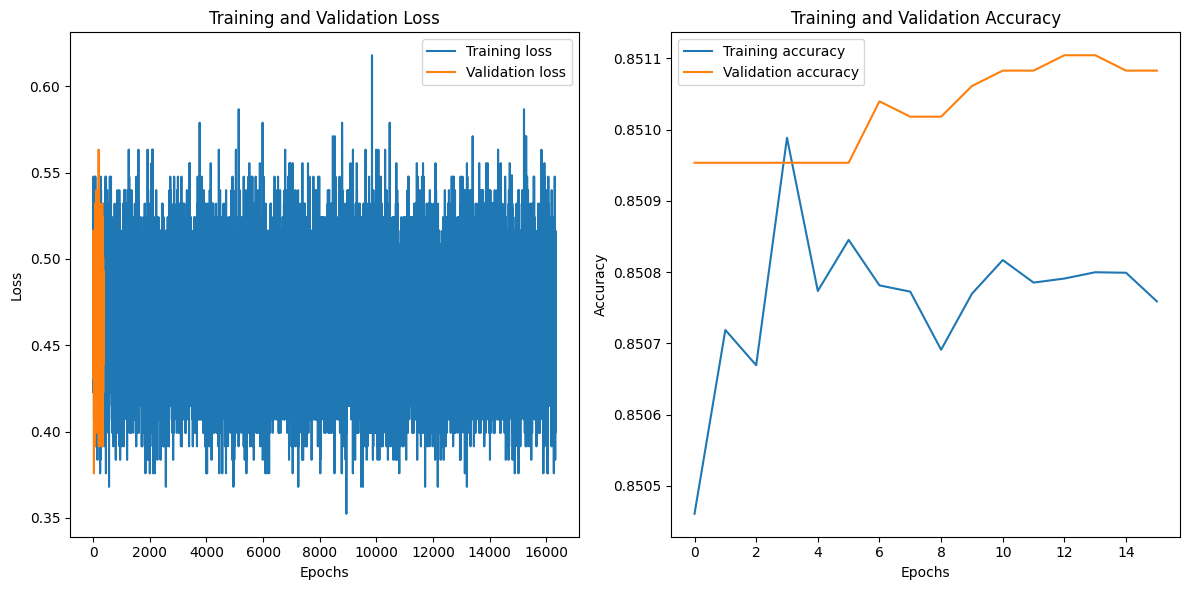

In [69]:

train()

In [ ]:
print(vocab_size)
print(embedding_dim)
print(hidden_size)
model = LSTMModel(vocab_size, embedding_dim, hidden_size)
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Define the training loop
# Define the training loop
num_epochs =
counter = 0
print_every = 1000
clip = 5

for epoch in range(num_epochs):
    model.train()  # Set the model to train mode
    total_loss = 0.0
    for batch in train_dl:
        inputs, targets = batch['text'].to(torch.long), batch['label'] # Unpack the batch
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs.squeeze(), targets.float())  # Calculate the loss
        print("Output Shape:", outputs.shape)
        print("Target Shape:", targets.shape)
        loss.backward()  # Backward pass
        optimizer.step()  # Update the parameters
        total_loss += loss.item() * inputs.size(0)


    # Calculate average loss for the epoch
    average_loss = total_loss / len(train_dl.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {average_loss}")

    # Evaluate on the validation set
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        valid_loss = 0.0
        for batch in valid_dl:
            inputs, targets = batch['text'].to(torch.long), batch['label'] # Unpack the batch
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs.squeeze(), targets.float())  # Calculate the loss
            valid_loss += loss.item() * inputs.size(0)

        # Calculate average validation loss
        average_valid_loss = valid_loss / len(valid_dl.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {average_valid_loss}")

# After training, you can evaluate the model on the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_loss = 0.0
    for batch in test_dl:
        inputs, targets = batch['text'].to(torch.long), batch['label'] # Unpack the batch
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs.squeeze(), targets.float())  # Calculate the loss
        test_loss += loss.item() * inputs.size(0)

    # Calculate average test loss
    average_test_loss = test_loss / len(test_dl.dataset)
    print(f"Test Loss: {average_test_loss}")


In [ ]:
class RNN:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Random Initial Weights
        self.Wx = np.random.randn(hidden_size, input_size) * 0.01
        self.Wxy = np.random.randn(hidden_size, hidden_size) * 0.01
        self.Wyz = np.random.randn(output_size, hidden_size) * 0.01
        self.Bh = np.zeros((hidden_size, 1))
        self.Bo = np.zeros((output_size, 1))

        self.learning_rate = learning_rate
        self.optimizer = None

    def forward(self, inputs, h_prev):
        self.a = np.dot(self.Wx, inputs) + np.dot(self.Wxy, h_prev) + self.Bh
        self.h = np.tanh(self.a)
        self.y = np.dot(self.Wyz, self.h) + self.Bo
        return self.y, self.h

    def backward(self, d_y, h, h_prev, inputs):
        d_Wyz = np.dot(d_y, self.h.T)
        d_Bo = d_y
        d_h = np.dot(self.Wyz.T, d_y)
        d_a = np.dot(1 - self.h ** 2, d_h)
        d_Bh = d_a
        d_Wxy = np.dot(d_a, h_prev.T)
        d_Wx = np.dot(d_a, inputs.T)
        d_h_prev = np.dot(self.Wxy.T, d_a)

        gradients = {
            'd_Wx': d_Wx,
            'd_Wxy': d_Wxy,
            'd_Wyz': d_Wyz,
            'd_Bh': d_Bh,
            'd_Bo': d_Bo,
            'd_h_prev': d_h_prev
        }
        return gradients

    def train_step(self, inputs, targets, h_prev):
        # Forward pass
        y_pred, hidden_state = self.forward(inputs, h_prev)

        # Calculate loss
        loss = np.mean((y_pred - targets)**2)

        # Backward pass
        gradients = self.backward(2 * (y_pred - targets), hidden_state, h_prev, inputs)

        # Update weights
        self.optimizer.step(self, gradients)

        return loss

In [ ]:

def train_model(dataloader):
    total_acc, total_loss = 0.0, 0.0
    for i, batch in enumerate(dataloader):
        print(f"Batch Index: {i}")
        text_batch = batch['text']
        label_batch = batch['label']
        lengths = batch['length']

        num_classes = 2  # Number of classes in your classification task
        label_batch_one_hot = torch.zeros(label_batch.size(0), num_classes, dtype=torch.float32)  # Initialize with float dtype
        label_batch_one_hot.scatter_(1, label_batch.unsqueeze(1).long(), 1)  # Convert label_batch to int64 using .long()

        h_prev = np.zeros((hidden_size, text_batch.shape[1]))  # Initialize hidden state
        print("Initial h_prev:", h_prev)
        loss = rnn_model.train_step(text_batch, label_batch, h_prev)
        print("Updated h_prev:", h_prev)

        total_loss += loss * text_batch.shape[1]

        pred = rnn_model.forward(text_batch, h_prev)[0]
        total_acc += ((pred >= 0.5).astype(float) == label_batch).astype(float).sum().item()

    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

In [ ]:
def evaluate(dataloader):
    total_acc, total_loss = 0.0, 0.0
    for i, batch in enumerate(dataloader):
        print(f"Batch Index: {i}")
        text_batch = batch['text']
        label_batch = batch['label']
        lengths = batch['length']

        h_prev = np.zeros((hidden_size, text_batch.shape[1]))  # Initialize hidden state
     # Initialize hidden state

        loss = rnn_model.train_step(text_batch, label_batch, h_prev)

        total_loss += loss * text_batch.shape[0]

        pred = rnn_model.forward(text_batch, h_prev)[0]
        total_acc += ((pred >= 0.5).astype(float) == label_batch).astype(float).sum().item()

    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)


In [ ]:

torch.manual_seed(1)
for epoch in range(num_epochs):
    acc_train, loss_train = train_model(train_dl)
